<a href="https://colab.research.google.com/github/PabloCavanzo/MetodosI_AntonioMorillo_PabloCavanzo/blob/main/Parcial%203/9.7.9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emcee
!pip install corner

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
import scipy.optimize as opt
import emcee
import corner

In [ ]:
# A)
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/Maxwell.csv'
df = pd.read_csv(url)
name = 'Maxwell.csv'
df.to_csv(name, index=False)
print('Archivo descargado y guardado como {}'.format(name))

Archivo descargado y guardado como Maxwell.csv


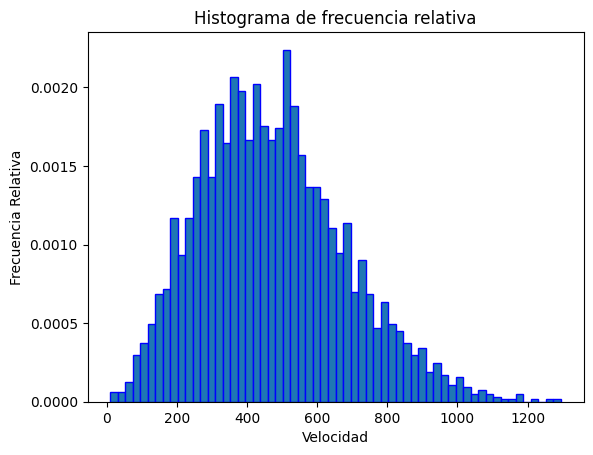

In [ ]:
# B)
velocidades = np.array(df['Velocidad'])
v_min, v_max = np.min(velocidades), np.max(velocidades)
N_bines = 60
freq, bins = np.histogram(velocidades, bins=N_bines, range=(v_min, v_max), density=True)
plt.bar(bins[:-1], freq, width=np.diff(bins), edgecolor='b', align='edge')
plt.xlabel('Velocidad')
plt.ylabel('Frecuencia Relativa')
plt.title('Histograma de frecuencia relativa')
plt.show()

El valor promedio empírico de la velocidad de las moleculas es: 472.18 m/s


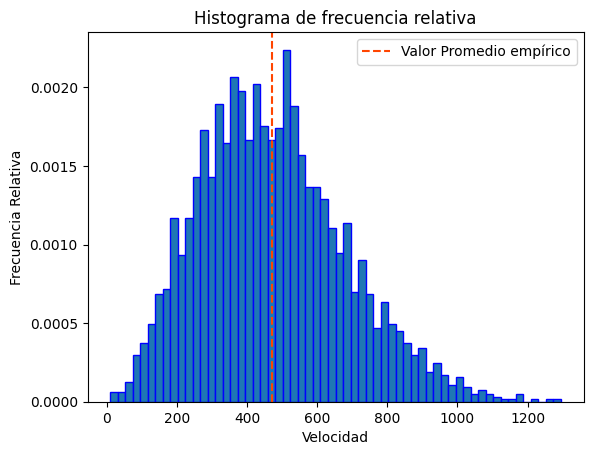

In [ ]:
# C)
promedio = np.mean(velocidades)
print('El valor promedio empírico de la velocidad de las moleculas es: {} m/s'.format(round(promedio,2)))
plt.bar(bins[:-1], freq, width=np.diff(bins), edgecolor='b', align='edge')
plt.xlabel('Velocidad')
plt.ylabel('Frecuencia Relativa')
plt.title('Histograma de frecuencia relativa')
plt.axvline(x=promedio, color='orangered', linestyle='--')
plt.legend(['Valor Promedio empírico'])
plt.show()

In [ ]:
# D)
M = 0.028 # Masa molar del nitrógeno en g/mol
Kb = 8.31
def Fn(v, T, m=M, k=Kb):
  return ((m/(2*(np.pi)*k*T))**(3/2))*4*(np.pi)*(v**2)*np.exp(-(m*v**2)/(2*k*T))

def Log_likelihood(v, T, m=M, k=Kb):
  return np.sum(np.log(Fn(v, T)))

def neg_Log_likelihood(T, v):
  return -Log_likelihood(v, T)

Temperatura estimada (T): 297.89 K ± 4.45 K


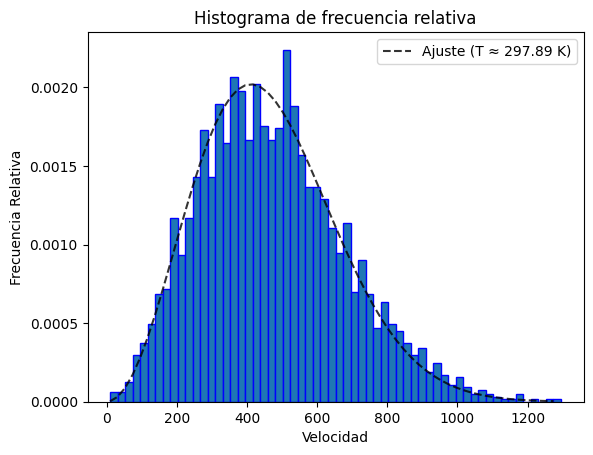

In [ ]:
# E) Ajuste de los datos:
result = opt.minimize(neg_Log_likelihood, 300, args=(velocidades,))
T_fit = result.x[0]
error_T = np.sqrt(np.diag(result.hess_inv))[0]
print(f"Temperatura estimada (T): {T_fit:.2f} K ± {error_T:.2f} K")

plt.bar(bins[:-1], freq, width=np.diff(bins), edgecolor='b', align='edge')
plt.xlabel('Velocidad')
plt.ylabel('Frecuencia Relativa')
plt.title('Histograma de frecuencia relativa')
plt.plot(bins[:-1], Fn(bins[:-1], *resultados), color='k', alpha=0.8, linestyle='--', label=f'Ajuste (T ≈ {T_fit:.2f} K)')
plt.legend()
plt.show()

Velocidad más probable (por ecuación): 420.50 m/s
Velocidad más probable (moda): 420.60 m/s


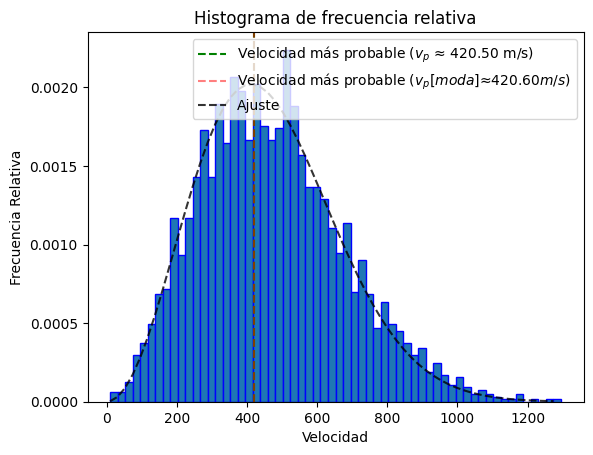

In [ ]:
# F)
vp = np.sqrt(2*Kb*T_fit/M)
print(f"Velocidad más probable (por ecuación): {vp:.2f} m/s")
Vs = np.linspace(v_min, v_max, 5000)
Fs = Fn(Vs, T_fit)
V_moda = Vs[np.argmax(Fs)]
print(f"Velocidad más probable (moda): {V_moda:.2f} m/s")

plt.bar(bins[:-1], freq, width=np.diff(bins), edgecolor='b', align='edge')
plt.xlabel('Velocidad')
plt.ylabel('Frecuencia Relativa')

plt.axvline(x=vp, color='green', linestyle='--', label=f"Velocidad más probable ($v_p$ ≈ {vp:.2f} m/s)")
plt.axvline(x=V_moda, color='red', alpha=0.5, linestyle='--', label=f"Velocidad más probable ($v_p [moda] ≈ {V_moda:.2f} m/s)$")
plt.title('Histograma de frecuencia relativa')
plt.plot(bins[:-1], Fn(bins[:-1], *resultados), color='k', alpha=0.8, linestyle='--', label='Ajuste')
plt.legend()
plt.show()

In [ ]:
# G)
v_m = vp*2/(np.sqrt(np.pi))
print(f'Velocidad promedio (v_m): {v_m:.2f} m/s')
print(f'Velocidad promedio empírica: {promedio:.2f} m/s')
print(f'Error relativo porcentual = {((np.abs(v_m - promedio)*100)/v_m):.2f} %')

Velocidad promedio (v_m): 474.49 m/s
Velocidad promedio empírica: 472.18 m/s
Error relativo porcentual = 0.49 %


# G) Razonamiento:
No, el valor de velocidad promedio ($v_m = \frac{2}{\sqrtπ}v_p$) no difiere casi del valor empírico. Esto se debe a que el error relativo porcentual entre ambas cantidades es tan solo del $0.49\%$.

In [ ]:
# H)
Rms = np.sqrt((3*Kb*T_fit)/M)
print(f'Velocidad cuadrática media (Rms): {Rms:.2f} m/s')

Velocidad cuadrática media (Rms): 515.01 m/s


100%|██████████| 5000/5000 [00:42<00:00, 116.58it/s]


Temperatura estimada (T): 298.00 K ± 4.42 K


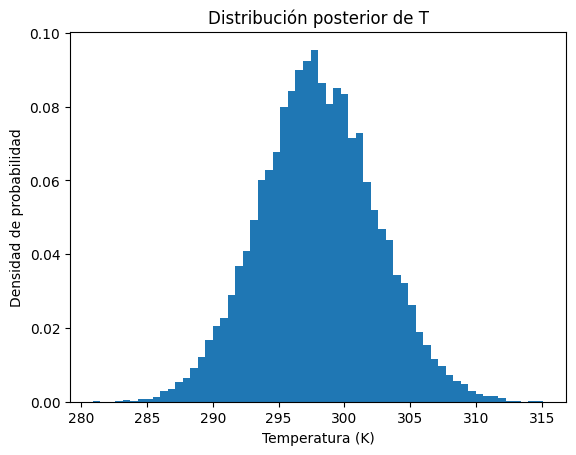

In [111]:
# I)
def LogPrior(T):
  if 0 < T < 1000:
    return 0.0
  return -np.inf

def LogPosterior(T, v):
  lp = LogPrior(T)
  if not np.isfinite(lp):
    return lp
  return lp + Log_likelihood(v, T)

n_walkers = 50
n_steps = 5000
n_params = 1

T_i = 280
Pos_i = T_i + 10 * np.random.randn(n_walkers, n_params)

sampler = emcee.EnsembleSampler(n_walkers, n_params, LogPosterior, args=(velocidades,))
pos,prob,state = sampler.run_mcmc(Pos_i, n_steps, progress=True)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

T_mean = np.mean(flat_samples)
T_std = np.std(flat_samples)

print(f"Temperatura estimada (T): {T_mean:.2f} K ± {T_std:.2f} K")
plt.hist(flat_samples, bins=60, density=True)
plt.xlabel('Temperatura (K)')
plt.ylabel('Densidad de probabilidad')
plt.title('Distribución posterior de T')
plt.show()

In [117]:
# J)
Intervalo_confianza = (T_mean - 1.95*T_std, T_mean + 1.95*T_std)
print(f'Intervalo para tener una confianza del 95% o mayor para T: {Intervalo_confianza[0]:.2f} K a {Intervalo_confianza[1]:.2f} K')
print(f'\nEsto significa que los modelos de temperatura mayores a Tˆ que están excluidos\ndada la observación son aquellos que consisten de una temperatura mayor a {Intervalo_confianza[1]:.2f} K')

Intervalo para tener una confianza del 95% o mayor para T: 289.38 K a 306.61 K

Esto significa que los modelos de temperatura mayores a Tˆ que están excluidos
dada la observación son aquellos que consisten de una temperatura mayor a 306.61 K
